In [5]:
import sys
import os

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
import importlib
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util
import augment_dataset

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import IPython.display as ipd

import scipy.signal
import scipy.io.wavfile


In [129]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs': 20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf': 125,
        'max_cf': 14e3,
        'spont_list': [70.0],
        'cohc': 1.0,
        'bandwidth_scale_factor': 1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}


sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 200
phase_mode = 'sine'
spectral_region = 'none'

freq_list = f0*np.arange(1, 60)

if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))

for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)


if spectral_region == 'low':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [125, 625], 'bandpass', filtfilt=True)
elif spectral_region == 'high':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [3900, 5400], 'bandpass', filtfilt=True)
elif spectral_region == 'custom':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [1e2, 1e4], 'bandpass', filtfilt=True)


snr = 12
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = dataset_util.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))
# y = signal
print(signal.shape, noise.shape, y.shape)

ipd.display(ipd.Audio(y, rate=sr))

out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)



(4800,) (4800,) (4800,)


In [7]:
for k in out_dict.keys():
    if isinstance(out_dict[k], np.ndarray):
        print(k, out_dict[k].shape)

cf_list (100,)
signal (1600,)
pin (5000,)
meanrates (100, 1000, 1)
spont_list (1,)


In [ ]:
def freq2erb(freq):
    return 21.4 * np.log10(0.00437 * freq + 1.0)

def erb2freq(erb):
    return (1.0/0.00437) * (10.0 ** (erb / 21.4) - 1.0)


fontsize=16

yticks = np.array([125, 368, 777, 1467, 2631, 4593, 7901, 14000])
yticks_erb = freq2erb(yticks)

fxx, pxx = dataset_util.power_spectrum(y, sr)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.5, 6))

ax.plot(pxx, freq2erb(fxx), 'k', lw=1.5)
ax.set_xlim([-5, 40])
ax.set_xticks([])
ax.set_ylim([yticks_erb[0], yticks_erb[-1]])
ax.set_yticks(yticks_erb)
ax.set_yticklabels(yticks, fontsize=fontsize)
ax.set_ylabel('Frequency (Hz)', fontsize=fontsize, fontweight='bold')
ax.set_xlabel('Power', fontsize=fontsize, fontweight='bold')

ax.tick_params(direction='out', axis='both', which='major', length=8, right=True, top=True)
ax.tick_params(direction='out', axis='both', which='minor', length=8, right=True, top=True)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
# ax.spines["left"].set_visible(False)

plt.show()

# save_dirname = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures'
# save_basename = 'tmp_spectrum_sideways_200HzF0_erb_scale.pdf'
# fig.savefig(os.path.join(save_dirname, save_basename), bbox_inches='tight')


In [ ]:
fontsize=16

fxx, pxx = dataset_util.power_spectrum(y, sr)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
ax.plot(fxx, pxx, color='k', lw=1)

ax.set_xlim([0, 8050])
ax.set_ylim([0, 30])
ax.set_xlabel('Frequency (Hz)', fontsize=fontsize)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

# save_dirname = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures'
# save_basename = 'tmp_spectrum_200HzF0_xlim8000Hz.pdf'
# fig.savefig(os.path.join(save_dirname, save_basename), bbox_inches='tight')


In [ ]:

fontsize=14

fidx = 60#81
print('cf=', freq[fidx])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75, 1.25))

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

ax.plot(mr_time, mr_trace, color='k', lw=3)

ax.set_xlim([0.0275, 0.0475])
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylim([0, np.max(mr_trace)*1.5])
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)

ax.set_ylabel('Spike rate', fontsize=fontsize, fontweight='bold')
ax.set_xlabel('Time', fontsize=fontsize, fontweight='bold')
plt.show()



In [ ]:
sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 250
phase_mode = 'sine'
spectral_region = 'custom'

freq_list = f0*np.arange(1, 60)

if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))

for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)


if spectral_region == 'low':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [125, 625], 'bandpass', filtfilt=True)
elif spectral_region == 'high':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [3900, 5400], 'bandpass', filtfilt=True)
elif spectral_region == 'custom':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [1e2, 1e4], 'bandpass', filtfilt=True)

# signal = np.sin(2*np.pi*5000*t)

snr = 100
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = dataset_util.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))
# y = signal

ipd.display(ipd.Audio(y, rate=sr))

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

color_list = ['k', 'b', 'r', 'y']
for cidx, IHC_cutoff in enumerate([5e3, 4e3, 3e3, 1e3]):

    kwargs_nervegram_meanrates = {
        'meanrates_params': {
            'dur': 0.050,
            'fs':100e3,
            'buffer_start_dur': 0.07,
            'buffer_end_dur': 0.01,
        },
        'ANmodel_params': {
            'num_cfs': 1,
            'min_cf':5000,
            'max_cf':5000,
            'spont_list':[70.0],
            'cohc':1.0,
            'bandwidth_scale_factor':1.0,
            'IhcLowPass_cutoff': IHC_cutoff,
            'IhcLowPass_order': 7,
        },
    }

    np.random.seed(0)
    out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)

    
    pin_fs = out_dict['pin_fs']
    pin = out_dict['pin']
    mr_fs = out_dict['meanrates_fs']
    mr = out_dict['meanrates']
    freq = out_dict['cf_list']
    pin_fs = out_dict['pin_fs']

    fidx = 0
    print('cf=', freq[fidx])

    mr_trace = mr[fidx, :, 0]
    mr_time = np.arange(0, mr.shape[1]) / mr_fs

    fxx, pxx = dataset_util.power_spectrum(mr_trace, mr_fs)

    ax[0].plot(mr_time, mr_trace, color=color_list[cidx])
    ax[1].plot(fxx, pxx, color=color_list[cidx], lw=4,
               label='IHC_cutoff={:.0f}Hz'.format(IHC_cutoff))
    
ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, Stimulus_F0={:.2f}'.format(freq[fidx], f0))
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylim([60, 120])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()

In [ ]:
pin_fs = out_dict['pin_fs']
pin = out_dict['pin']
mr_fs = out_dict['meanrates_fs']
mr = out_dict['meanrates']
freq = out_dict['cf_list']
pin_fs = out_dict['pin_fs']

fidx = 0
print('cf=', freq[fidx])

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

fxx, pxx = dataset_util.power_spectrum(mr_trace, mr_fs)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
ax[0].plot(mr_time, mr_trace, color='k')
ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, IHC_cutoff={:.2f}'.format(freq[fidx], IHC_cutoff))


ax[1].axvline(IHC_cutoff, color='r', label='IHC_cutoff')
ax[1].axvline(5000, color='b', ls='--', lw=0.5, label='old Nyquist')
ax[1].plot(fxx, pxx, color='k')
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

signal = np.random.randn(1000)
noise = np.random.rand(1000)

snr = 60

signal = signal - np.mean(signal)
noise = noise - np.mean(noise)

signal = 0.2 * signal

In [ ]:
signal = signal - np.mean(signal)
noise = noise - np.mean(noise)

print(np.sqrt(np.mean(np.square(signal))), 20 * np.log10(np.sqrt(np.mean(np.square(signal))) / 2e-5))

if np.isinf(snr) and snr < 0:
    signal = noise
elif np.isinf(snr) and snr > 0:
    signal = signal
else:
    rms_signal = np.sqrt(np.mean(np.square(signal)))
    rms_noise = np.sqrt(np.mean(np.square(noise)))
    rms_noise_scaling = rms_signal / (rms_noise * np.power(10, snr / 20))
    rf_signal = np.sqrt(np.mean(np.square(signal)))
    rf_noise = np.sqrt(np.mean(np.square(rms_noise_scaling * noise)))
    signal = signal + rms_noise_scaling * noise
    rf_combined = np.sqrt(np.mean(np.square(signal)))
    print(rf_signal/rf_noise, np.power(10, snr / 20))
    print(rf_combined)

print(np.sqrt(np.mean(np.square(signal))), 20 * np.log10(np.sqrt(np.mean(np.square(signal))) / 2e-5))


In [130]:
importlib.reload(bez2018model)

kwargs_nervegram_meanrates = {
    'nervegram_params': {
        'dur': 0.050,
        'fs': 10e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_anfs': 20,
        'num_cfs': 100,
        'min_cf': 125,
        'max_cf': 14e3,
        'spont_list': [70.0],
        'cohc': 1.0,
        'bandwidth_scale_factor': 1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}
out_dict = bez2018model.nervegram_psth(y, sr, **kwargs_nervegram_meanrates)

for k in sorted(out_dict.keys()):
    if isinstance(out_dict[k], np.ndarray):
        print(k, out_dict[k].shape, out_dict[k].dtype)
    else:
        print(k)


IhcLowPass_cutoff
IhcLowPass_order
bandwidth_scale_factor
buffer_end_dur
buffer_start_dur
cf_list (100,) float32
cihc
cohc
implnt
nervegram_dur
nervegram_fs
nervegram_meanrates (100, 500, 1) float32
nervegram_psth (100, 500, 1, 20) float64
noiseType
pin (5000,) float32
pin_dBSPL
pin_dBSPL_flag
pin_fs
signal (1600,) float32
signal_fs
species
spont_list (1,) float32
tabs
trel


In [140]:
# rate = out_dict['nervegram_meanrates']
# rate_sr = out_dict['nervegram_fs']
# nervegram_binomial = np.zeros_like(out_dict['nervegram_psth'])
# for itrANF in range(nervegram_binomial.shape[-1]):
#     spikes = np.sign((rate/rate_sr) - np.random.rand(*rate.shape))
#     spikes[spikes < 0] = 0
#     nervegram_binomial[:, :, :, itrANF] = spikes


rate = np.zeros_like(out_dict['nervegram_psth'])
for itrANF in range(rate.shape[-1]):
    rate[:, :, :, itrANF] = out_dict['nervegram_meanrates'].copy()
print(rate.shape)

rate_sr = out_dict['nervegram_fs']
nervegram_binomial = np.zeros_like(out_dict['nervegram_psth'])
dur_refract = int(0.004 * rate_sr)
print(dur_refract)
for t in range(rate.shape[1]):
    t_prob = rate[:, t:t+1, :, :] / rate_sr
    t_spks = np.sign(t_prob - np.random.rand(*t_prob.shape))
    t_spks[t_spks < 0] = 0
#     if t < rate.shape[1] - 1:
#         t_end = min(t + 1 + dur_refract, rate.shape[1])
#         rate[:, t+1:t_end, :, :] *= t_spks == 0
    for t_refract in range(t + 1, t + 1 + dur_refract):
        if t_refract >= rate.shape[1]:
            break
        rate[:, t_refract:t_refract+1, :, :] *= t_spks == 0
    nervegram_binomial[:, t:t+1, :, :] = t_spks

nervegram_binomial.shape


(100, 500, 1, 20)
40


(100, 500, 1, 20)

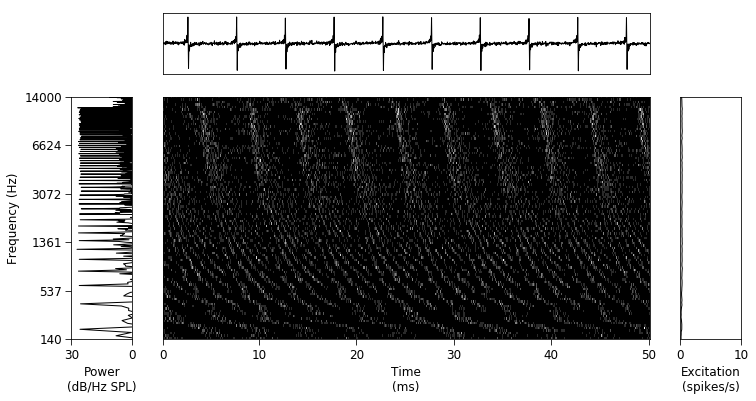

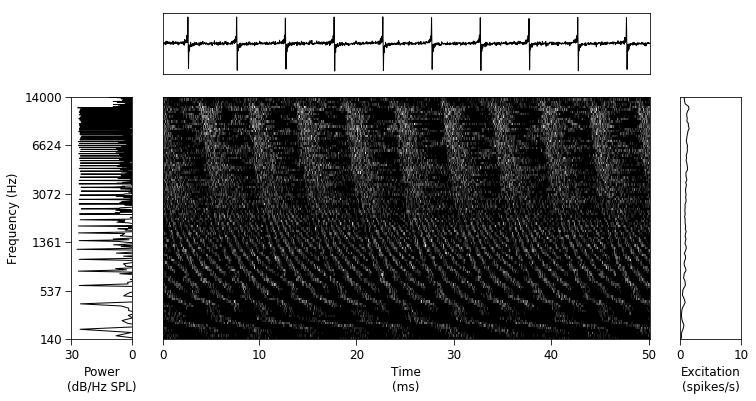

In [136]:
figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}


waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
nervegram = np.sum(out_dict['nervegram_psth'][:, :, :, 0:200], axis=-1)
# nervegram = np.sum(nervegram_binomial[:, :, :, 0:200], axis=-1)
# nervegram = out_dict['nervegram_meanrates']
sr_nervegram = out_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()




nervegram = np.sum(nervegram_binomial[:, :, :, 0:200], axis=-1)

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()


(100, 500, 1, 20) (100, 500, 1, 20)


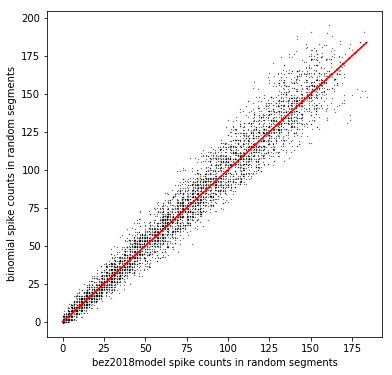

In [141]:
spike_counts_1 = []
spike_counts_2 = []

nervegram_1 = out_dict['nervegram_psth']
nervegram_2 = nervegram_binomial

print(nervegram_1.shape, nervegram_2.shape)
assert nervegram_1.shape == nervegram_2.shape
for _ in range(5000):
    idx_cf = np.random.randint(nervegram_1.shape[0])
    idx_dur = np.random.randint(nervegram_1.shape[1])
    idx_start = np.random.randint(nervegram_1.shape[1] - idx_dur)
    idx_anf = np.random.randint(nervegram_1.shape[3])
    
    spike_counts_1.append( np.sum(nervegram_1[idx_cf, idx_start:idx_start+idx_dur, 0, :]) )
    spike_counts_2.append( np.sum(nervegram_2[idx_cf, idx_start:idx_start+idx_dur, 0, :]) )

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(spike_counts_1, spike_counts_2, 'k.', ms=0.5)
ax.plot(spike_counts_1, spike_counts_1, 'r--')
ax.set_xlabel('bez2018model spike counts in random segments')
ax.set_ylabel('binomial spike counts in random segments')

plt.show()


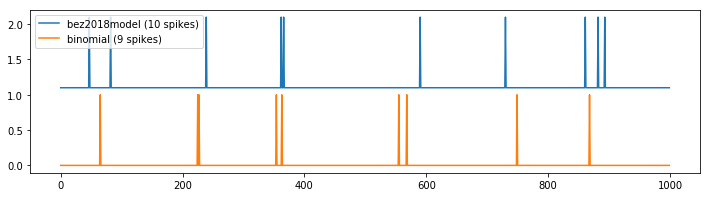

9.0 10.0


In [79]:
cf_idx = 0
num_anfs = 2

bez2018model_spikes = np.sum(out_dict['nervegram_psth'][cf_idx:cf_idx+1, :, :, -num_anfs:], axis=(0, 2, 3))

bez2018model_label = 'bez2018model ({} spikes)'.format(int(bez2018model_spikes.sum()))

rate_sr = out_dict['nervegram_fs']
rate = out_dict['nervegram_meanrates'][cf_idx, : , 0]
binomial_spikes = np.zeros_like(rate)
for itrANF in range(num_anfs):
    spikes = np.sign((rate/rate_sr) - np.random.rand(*rate.shape))
    spikes[spikes < 0] = 0
    binomial_spikes = binomial_spikes + spikes
binomial_label = 'binomial ({} spikes)'.format(int(binomial_spikes.sum()))


fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(bez2018model_spikes + np.max(binomial_spikes) * 1.1, label=bez2018model_label)
ax.plot(binomial_spikes, label=binomial_label)
ax.legend()
plt.show()
